In [39]:
# Import necessary libraries.
import re, string, unicodedata
import pandas as pd
import nltk  
import numpy as np                                      # Import numpy.         
                        # Natural language processing tool-kit
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!pip install contractions
#from contractions import contractions_dict
import contractions


from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [41]:
# Load dataset.
dataset = pd.read_csv('/content/gdrive/My Drive/Tweets.csv')

In [42]:
# Check first 5 rows of data.
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [43]:
dataset.shape

(14640, 15)

In [44]:
dataset.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [45]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [46]:
# Here we are going to deal with text data, so we seperate out the text column in a new dataframe: data
data = dataset.drop(['tweet_id','airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'], axis=1)

In [47]:
data.shape

(14640, 2)

In [48]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [49]:
# second row of data.
pd.set_option('display.max_colwidth', None) # It will enable the entire row visible with truncation of the text. (We can see full text.)
data.loc[[1]]

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.


In [50]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Perform the above operation over all the rows of text column of the dataframe.
for i, row in data.iterrows():
    text = data.at[i, 'text']
    clean_text = replace_contractions(text)
    data.at[i,'text'] = clean_text
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [51]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [52]:
# Removal of  @airlinename using Regular Expression.
for i, row in data.iterrows():
    clean_text = re.sub(r"@\S+", "", data.at[i, 'text'])
    data.at[i,'text'] = clean_text
data.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


In [53]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


In [54]:
# Tokenize the words of whole dataframe.
for i, row in data.iterrows():
    text = data.at[i, 'text']
    words = nltk.word_tokenize(text)
    data.at[i,'text'] = words
data.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [55]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [56]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

In [57]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [58]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

In [59]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)    
    return words

In [60]:
# Iterate the normalize funtion over whole data.
for i, row in data.iterrows():
    words = data.at[i, 'text']
    words = normalize(words)
    data.at[i,'text'] = words
data.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,"[i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [61]:
data['lemma'] = ''

for i, row in data.iterrows():
    words = data.at[i, 'text']
    lemmas = lemmatize_verbs(words)    
    data.at[i, 'lemma'] = lemmas
data.head()

,airline_sentiment,text,lemma
0,neutral,"[what, said]","[what, say]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, tacky]","[plus, you, have, add, commercials, to, the, experience, tacky]"
2,neutral,"[i, did, not, today, must, mean, i, need, to, take, another, trip]","[i, do, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]","[it, be, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]","[and, it, be, a, really, big, bad, thing, about, it]"


In [62]:
# Join tokens to create new Text column .
def to_text(words):
   new_text = ""                 # Create empty string to add tokens to .
   for word in words:
        new_text = new_text + " " + word         #join tokens in text list
   return new_text

for i, row in data.iterrows():
    words = data.at[i, 'lemma']
    text1 = to_text(words)    
    data.at[i, 'new_text'] = text1
data.head()

,airline_sentiment,text,lemma,new_text
0,neutral,"[what, said]","[what, say]",what say
1,positive,"[plus, you, have, added, commercials, to, the, experience, tacky]","[plus, you, have, add, commercials, to, the, experience, tacky]",plus you have add commercials to the experience tacky
2,neutral,"[i, did, not, today, must, mean, i, need, to, take, another, trip]","[i, do, not, today, must, mean, i, need, to, take, another, trip]",i do not today must mean i need to take another trip
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]","[it, be, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]",it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]","[and, it, be, a, really, big, bad, thing, about, it]",and it be a really big bad thing about it


In [63]:
#Manual encode sentiments
label_dict =  {'neutral':0, 'negative':1, 'positive':2 }
data['airline_sentiment'] = data['airline_sentiment'].replace(label_dict)
data.head()

,airline_sentiment,text,lemma,new_text
0,0,"[what, said]","[what, say]",what say
1,2,"[plus, you, have, added, commercials, to, the, experience, tacky]","[plus, you, have, add, commercials, to, the, experience, tacky]",plus you have add commercials to the experience tacky
2,0,"[i, did, not, today, must, mean, i, need, to, take, another, trip]","[i, do, not, today, must, mean, i, need, to, take, another, trip]",i do not today must mean i need to take another trip
3,1,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]","[it, be, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]",it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,1,"[and, it, is, a, really, big, bad, thing, about, it]","[and, it, be, a, really, big, bad, thing, about, it]",and it be a really big bad thing about it


In [64]:
labels = data['airline_sentiment']
labels = labels.astype('int')

In [65]:

# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['new_text'])

data_features = data_features.toarray()                        # Convert the data features to array.
print(data_features.shape)
print(data_features)

(14640, 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [66]:
 # Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [67]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7435109289617486


In [68]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

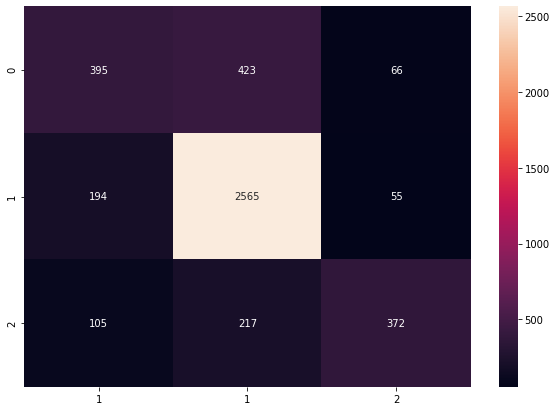

In [69]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

conf_mat = confusion_matrix(y_test, result)



df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "112"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [70]:
cr=metrics.classification_report(y_test,result)
print(cr)

              precision    recall  f1-score   support

           0       0.57      0.45      0.50       884
           1       0.80      0.91      0.85      2814
           2       0.75      0.54      0.63       694

    accuracy                           0.76      4392
   macro avg       0.71      0.63      0.66      4392
weighted avg       0.75      0.76      0.75      4392



In [71]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(data['new_text'])

data_features = data_features.toarray()

data_features.shape

(14640, 1000)

In [72]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7417349726775956


In [74]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

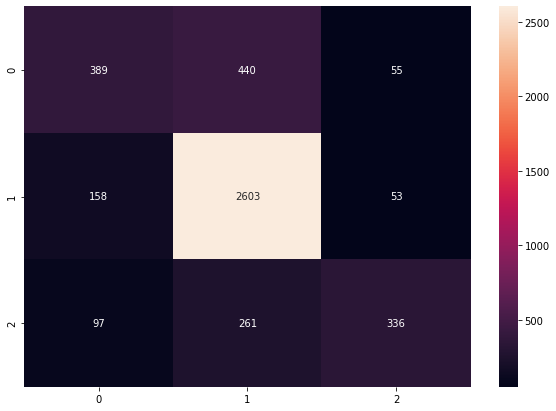

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

conf_mat = confusion_matrix(y_test, result)



df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')



In [76]:
cr=metrics.classification_report(y_test,result)
print(cr)

              precision    recall  f1-score   support

           0       0.60      0.44      0.51       884
           1       0.79      0.93      0.85      2814
           2       0.76      0.48      0.59       694

    accuracy                           0.76      4392
   macro avg       0.72      0.62      0.65      4392
weighted avg       0.75      0.76      0.74      4392



The dataset contains passengers tweets about various airlines  and thier sentiment about them in text format positive, neutral and negative.

We built a classification model that can review user's tweets and predict thier sentiment about the airline.

Various preprocesing technigues were implemented to clean up the data , removing html tags, numbers , special characters etc.

We also reduced some words to thier root words using leminization, stop words were not removed, since the question did not request that we do so 

We than converted user's text tweets into numbers using bag of words and TF-IDF Vectorizer methods, this enabled us to feed the data to a model 
We manually encoded user sentiments as follows neutral:0, 'negative':1, 'positive':2

We then built the classification model using randomforest technique,
after building the model we predicted results based on test data 

For both bag of words and TF-IDF our model performed well in terms of accuracy , had high precision and recall for predicting negative sentimets but lower precision and recall for neutral and positive sentiment, meaning that it can more accurately identify users that has negative sentiment about the airline. 
We can improve the performance of the model by optimizing the performance of the randomforest classification model or trying out other methods. we can also optimze text preprocessing techquies